In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import os
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 9)

In [2]:
def save_frames(video_path, output_dir, verbose=True):
    video = cv2.VideoCapture(video_path)
    success, image = video.read()
    c = 0
    while success:
        cv2.imwrite(os.path.join(output_dir, f"frame{c}.jpg"), image)
        if verbose:
            print(f'Saved frame: {c}')
        success, image = video.read()
        c += 1

In [3]:
# save_frames('../data/train.mp4', '../data/training_images')
# save_frames('../data/test.mp4', '../data/test_images')

In [4]:
def load_dataset(image_dir, labels_path, lim=None):
    Y = np.loadtxt('../data/train.txt')
    if lim is not None:
        Y = Y[:lim]
    X = np.array([cv2.imread(os.path.join(image_dir, f'frame{i}.jpg'), cv2.IMREAD_COLOR) for i in trange(Y.shape[0])])
    return X, Y

In [5]:
X, Y = load_dataset('../data/training_images', '../data/train.txt', 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
def show_grid(images, grid=(4, 4)):
    if isinstance(grid, int):
        grid = (grid, grid)
    
    h, w = grid
    size = h * w
    if len(images) != size:
        raise ValueError(f"Invalid number of images passed, got {len(images)} images, expected {size} images for grid of size {grid}")
    
    image_grid = np.vstack([np.hstack(images[i:i+w]) for i in range(0, size, w)])
    plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(image_grid, cv2.COLOR_BGR2RGB))
    plt.show()

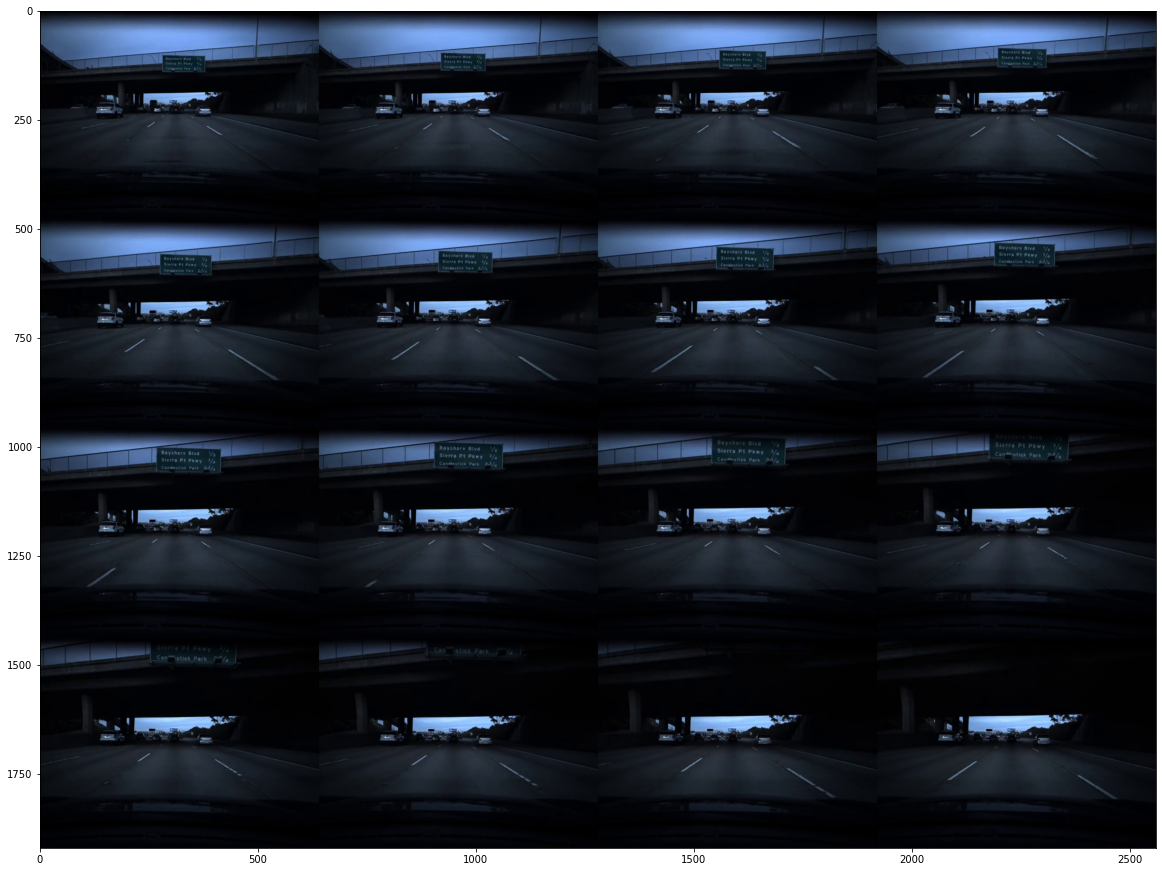

In [7]:
show_grid(X[:16])

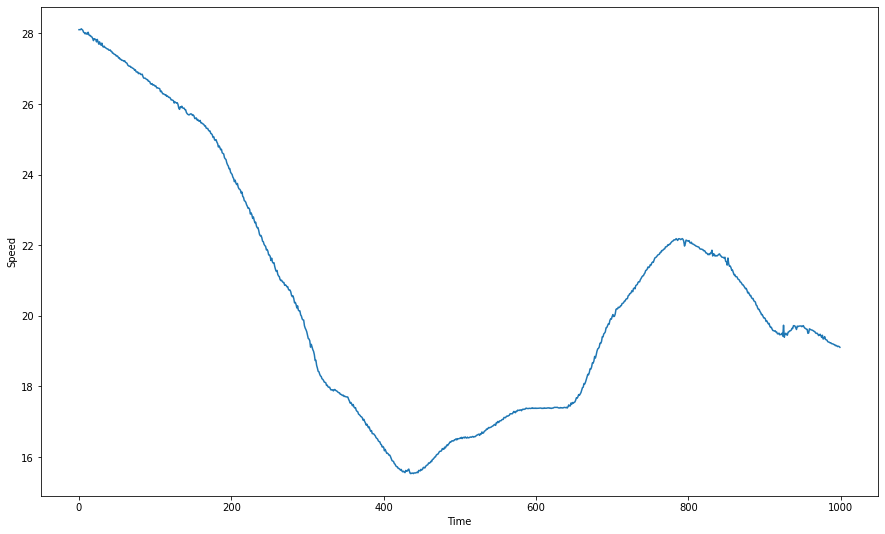

In [8]:
plt.plot(Y)
plt.ylabel('Speed')
plt.xlabel('Time')
plt.show()

In [9]:
def preprocess_image(image, bright_factor=.2, size=(320, 170)):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    image_rgb = image_rgb[100:440]  # Cut out sky and car dashboard
    resized = cv2.resize(image_rgb[100:440], size, interpolation=cv2.INTER_AREA)  # Resize to speed up processing
    return resized

def optical_flow(prev, curr):
    hsv = np.zeros_like(prev, dtype=np.uint8)
    prev, curr = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY), cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev, curr, None, 0.5, 1, 15, 2, 5, 1.3, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[:,:,1] = 255
    hsv[:,:,0] = ang * (180 / np.pi / 2)
    hsv[:,:,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    return bgr_flow

def images_to_flow(images, bright_factor=.2, size=(320, 170)):
    flow = np.zeros((images.shape[0] - 1, *reversed(size), images.shape[-1]), dtype=np.uint8)
    for idx, (prev, curr) in tqdm(enumerate(zip(images, images[1:])), total=images.shape[0] - 1):
        prev, curr = preprocess_image(prev, bright_factor, size), preprocess_image(curr, bright_factor, size)
        flow[idx] = optical_flow(prev, curr)
    return flow

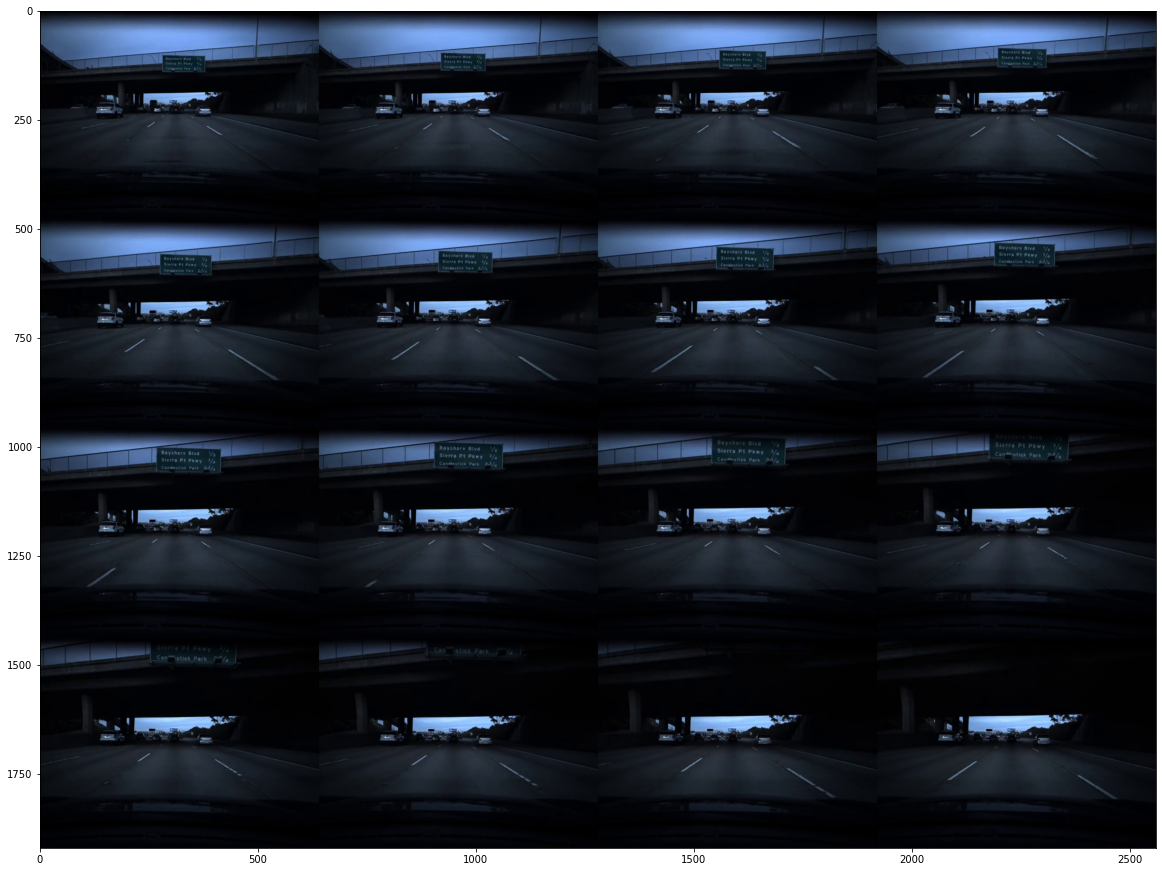

In [10]:
show_grid(X[:16])

  0%|          | 0/9 [00:00<?, ?it/s]

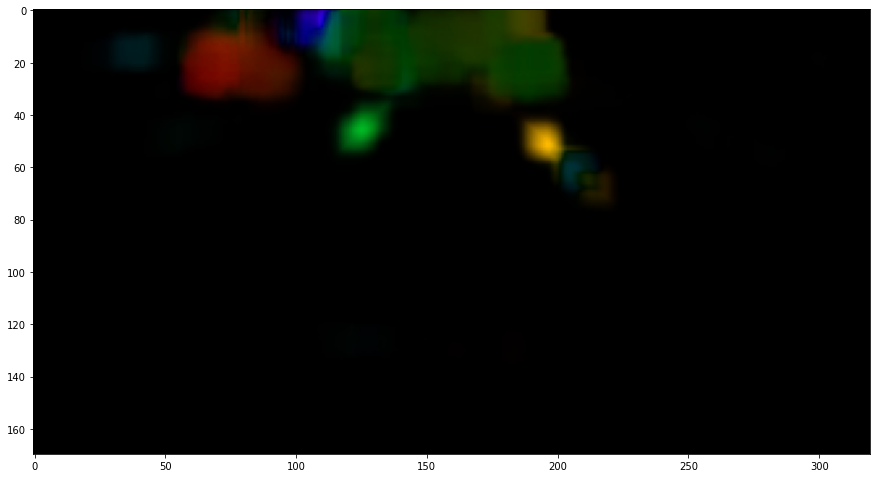

In [11]:
flow = images_to_flow(X[:10], bright_factor=.2)
plt.imshow(cv2.cvtColor(flow[0], cv2.COLOR_BGR2RGB))

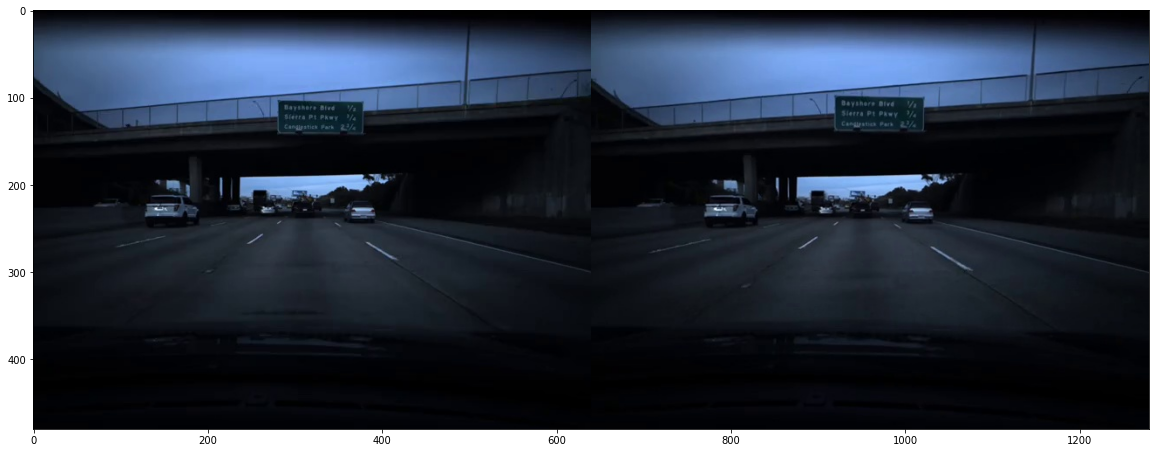

In [12]:
show_grid(X[:2], (1, 2))